# Práctica 4 de IA

# 3. Procesamiento de texto y datos no balanceados (4,5 puntos)

In [8]:
import pandas as pd

df = pd.read_csv("train.tsv", sep='\t', index_col="PhraseId")
# pd.set_option('display.max_colwidth', None)
df.head(2)

,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,A series of escapades demonstrating the adage ...,1
2,1,A series of escapades demonstrating the adage ...,2


Este conjunto de datos que usaremos ahora permite aprender el sentimiento del texto a partir de frases etiquetadas.
Las etiquetas para los sentimientos son:

* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

Más información [aquí](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews).


A lo largo de este ejercicio veremos distintas formas de procesar el texto y de equilibrar las clases a aprender.

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df[["Phrase", "Sentiment"]], random_state=0)
X_train = train.Phrase
X_test = test.Phrase
y_train = train.Sentiment
y_test = test.Sentiment

**Modelos básicos**

Vamos a comenzar con una concatenación (*pipe*) de modelos muy básicos y analizaremos si tienen algún problema.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

count_vectorizer = CountVectorizer(max_features=1000)
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=2)
pipe = make_pipeline(count_vectorizer,decision_tree)

In [11]:
from sklearn.metrics import accuracy_score

def get_accuracy(pipe):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return round(accuracy_score(y_pred, y_test),3)

In [12]:
get_accuracy(pipe)

0.515

Veamos qué clases se están prediciendo de verdad

In [14]:
# Etiquetas de entrenamiento
round(pd.Series(y_train).value_counts(normalize=True),2)

2    0.51
3    0.21
1    0.17
4    0.06
0    0.04
Name: Sentiment, dtype: float64

In [13]:
# Clases en predicción
y_pred = pipe.predict(X_test)
round(pd.Series(y_pred).value_counts(normalize=True),2)

2    0.97
3    0.03
dtype: float64

Es decir: al ser un problema no balanceado, la predicción está claramente sesgada hacia una de las clases.

Esto se puede ver también analizando la **matriz de confusión**

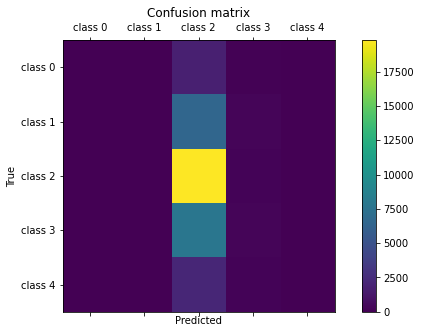

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(pipe):
    ticks = np.unique(y_test)
    labels = [('class '+ str(tick)) for tick in ticks]
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(pipe)

## Cambio de modelos y procesamiento de los datos

Analiza si algún otro modelo de los vistos en ejercicios anteriores evita este problema de las clases desbalanceadas.

Por ejemplo, en la celda siguiente se cambia el árbol de decisión por un KNN.

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
pipe_knn = make_pipeline(count_vectorizer,knn)
get_accuracy(pipe_knn)

0.564

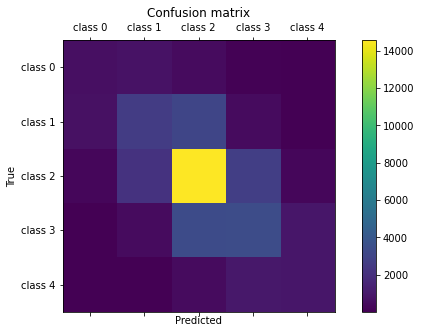

In [26]:
plot_confusion_matrix(pipe_knn)

### Explora varios modelos y responde:

* ¿Con qué modelo se obtienen mejores resultados?
* ¿Hay algún parámetro de los modelos que sea particularmente efectivo en evitar el desbalanceo?

Nota: incluye tantas celdas como precises para enseñar el código que has usado para responder a estas preguntas.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [17]:
def multiplot_accuracy_graph(accuracies, params, param, title):
    plt.plot(params, accuracies)
    plt.title(title)
    plt.xlabel(param)
    plt.ylabel('Accuracy')
    plt.show()

In [11]:
pipes = [[],[]]
params = [[],[]]
accuracies_dt = [[],[]]
i = 0
for criterion in ["gini", "entropy"]:
    for max_depth in range(1,200,10):
        count_vectorizer = CountVectorizer(max_features=1000)
        decision_tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
        pipe = make_pipeline(count_vectorizer,decision_tree)
        pipe.fit(X_train, y_train)
        pipes[i].append(pipe)
        params[i].append(max_depth)
    accuracies_dt[i] = [get_accuracy(pipe) for pipe in pipes[i]]
    i += 1


In [18]:
# La celda anterior tarda 10 minutos en ejecutar.
# Los resultados son los siguientes
params = [[],[]]
accuracies_dt = [[],[]]
accuracies_dt[0] = [0.512, 0.533, 0.547, 0.559, 0.57, 0.576, 0.582, 0.584, 0.588, 0.59, 0.592, 0.592, 0.596, 0.595, 0.596, 0.595, 0.596, 0.594, 0.595, 0.595]
accuracies_dt[1] = [0.512, 0.533, 0.546, 0.557, 0.567, 0.573, 0.578, 0.583, 0.586, 0.588, 0.589, 0.59, 0.591, 0.592, 0.593, 0.593, 0.594, 0.594, 0.593, 0.592]
params[0] = params[1] = range(1,200,10)

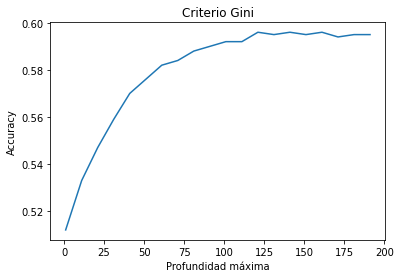

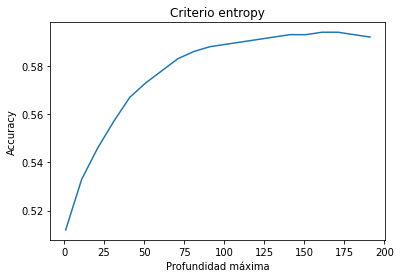

121 161


In [19]:
multiplot_accuracy_graph(accuracies_dt[0], params[0], 'Profundidad máxima', 'Criterio Gini')
multiplot_accuracy_graph(accuracies_dt[1], params[1], 'Profundidad máxima', 'Criterio entropy')
print(range(1,200,10)[accuracies_dt[0].index(max(accuracies_dt[0]))], range(1,200,10)[accuracies_dt[1].index(max(accuracies_dt[1]))])

In [ ]:
pipes =  [[[], []], [[], []]]
params = [[[], []], [[], []]]
accuracies_knn = [[[], []], [[], []]]

i = 0
for weights in ["uniform", "distance"]:
    j = 0
    for p in [1, 2]:
        for k in [2*i+1 for i in range(25)]:
            count_vectorizer = CountVectorizer(max_features=1000)
            knn = KNeighborsClassifier(n_neighbors=k, weights=weights, p=p)
            pipe = make_pipeline(count_vectorizer,knn)
            pipe.fit(X_train, y_train)
            pipes[i][j].append(pipe)
            params[i][j].append(k)
        accuracies_knn[i][j] = [get_accuracy(pipe) for pipe in pipes[i][j]]
        j += 1
    i += 1

In [32]:
# La ejecucion de la celda anterior tarda en torno a 3 horas
# Los resultados son los siguientes
accuracies_knn = [[[], []], [[], []]]
params = [[[], []], [[], []]]
accuracies_knn[0][0] = [0.564, 0.562, 0.585, 0.579, 0.574, 0.572, 0.566, 0.559, 0.554, 0.549, 0.544, 0.54, 0.537, 0.535, 0.533, 0.531, 0.53, 0.529, 0.527, 0.526, 0.525, 0.524, 0.524, 0.523, 0.523]
accuracies_knn[0][1] = [0.564, 0.562, 0.572, 0.57, 0.566, 0.569, 0.556, 0.56, 0.555, 0.548, 0.545, 0.542, 0.539, 0.537, 0.534, 0.532, 0.531, 0.529, 0.527, 0.527, 0.526, 0.524, 0.524, 0.523, 0.523]
accuracies_knn[1][0] = [0.564, 0.575, 0.596, 0.597, 0.599, 0.601, 0.599, 0.597, 0.594, 0.593, 0.591, 0.589, 0.587, 0.586, 0.585, 0.583, 0.582, 0.581, 0.58, 0.578, 0.578, 0.577, 0.576, 0.575, 0.574]
accuracies_knn[1][1] = [0.564, 0.573, 0.582, 0.584, 0.585, 0.592, 0.582, 0.589, 0.587, 0.584, 0.583, 0.581, 0.579, 0.578, 0.576, 0.575, 0.573, 0.572, 0.572, 0.571, 0.569, 0.568, 0.568, 0.567, 0.567]
params[0][0] = params [0][1] = params[1][0] = params[1][1] = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]


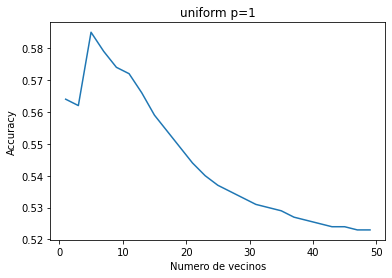

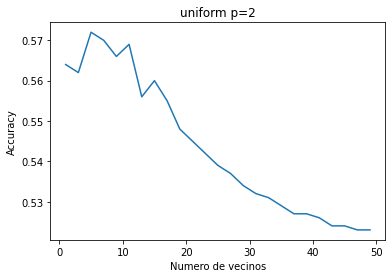

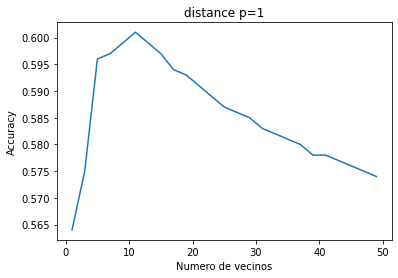

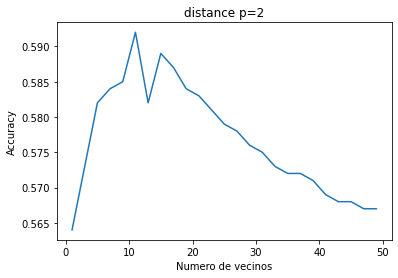

In [33]:
multiplot_accuracy_graph(accuracies_knn[0][0], params[0][0], 'Numero de vecinos', 'uniform p=1')
multiplot_accuracy_graph(accuracies_knn[0][1], params[0][1], 'Numero de vecinos', 'uniform p=2')
multiplot_accuracy_graph(accuracies_knn[1][0], params[1][0], 'Numero de vecinos', 'distance p=1')
multiplot_accuracy_graph(accuracies_knn[1][1], params[1][1], 'Numero de vecinos', 'distance p=2')

In [ ]:
pipes =  [[], [], [], []]
params = [[], [], [], []]
accuracies_nnet = [[], [], [], []]

i = 0
for early_stopping in [True, False]:
    count_vectorizer = CountVectorizer(max_features=1000)
    nnet = MLPClassifier(early_stopping=early_stopping)
    pipe = make_pipeline(count_vectorizer,nnet)
    pipe.fit(X_train, y_train)
    pipes[i].append(pipe)
    params[i].append(early_stopping)

i += 1
for learning_rate_init in [0.0001, 0.001, 0.01, 0.1, 1]:
    count_vectorizer = CountVectorizer(max_features=1000)
    nnet = MLPClassifier(learning_rate_init=learning_rate_init)
    pipe = make_pipeline(count_vectorizer,nnet)
    pipe.fit(X_train, y_train)
    pipes[i].append(pipe)
    params[i].append(learning_rate_init)

i += 1
for hidden_layer_sizes in [(2,), (10,), (2,2,), (10,10,), (2,2,2,), (10,10,10,)]:
    count_vectorizer = CountVectorizer(max_features=1000)
    nnet = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes)
    pipe = make_pipeline(count_vectorizer,nnet)
    pipe.fit(X_train, y_train)
    pipes[i].append(pipe)
    params[i].append(hidden_layer_sizes)

i += 1
for alpha in [0.0001, 0.001, 0.01, 0.1, 1]:
    count_vectorizer = CountVectorizer(max_features=1000)
    nnet = MLPClassifier(alpha=alpha)
    pipe = make_pipeline(count_vectorizer,nnet)
    pipe.fit(X_train, y_train)
    pipes[i].append(pipe)
    params[i].append(alpha)


for i in range(4):
    accuracies_nnet[i] = [get_accuracy(pipe) for pipe in pipes[i]]

In [22]:
# La ejecucion de la celda superior tarda 1h y media
# Los resultados son los siguientes
params = [[], [], [], []]
accuracies_nnet = [[], [], [], []]
accuracies_nnet[0] = [0.619, 0.593]
accuracies_nnet[1] = [0.621, 0.594, 0.592, 0.576, 0.512]
accuracies_nnet[2] = [0.585, 0.604, 0.585, 0.603, 0.579, 0.6]
accuracies_nnet[3] = [0.594, 0.597, 0.602, 0.62, 0.552]
params[0] = [True, False]
params[1] = [0.0001, 0.001, 0.01, 0.1, 1]
params[2] = [(2,), (10,), (2, 2,), (10, 10,), (2, 2, 2,), (10, 10, 10,)]
params[3] = [0.0001, 0.001, 0.01, 0.1, 1]

Variando early_stopping...
    early_stopping = True 0.619
    early_stopping = False 0.593


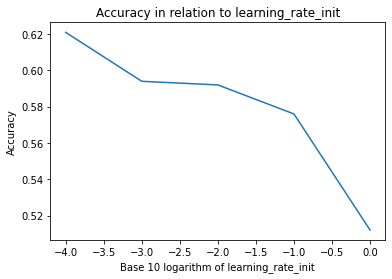

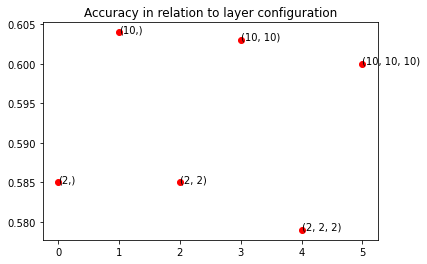

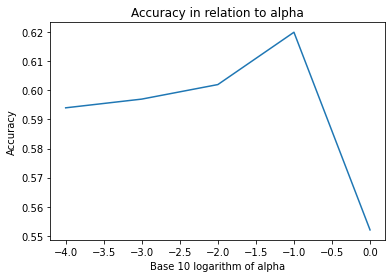

In [23]:
from math import log

print('Variando early_stopping...')
print('    early_stopping = True', accuracies_nnet[0][0])
print('    early_stopping = False', accuracies_nnet[0][1])

log(0.01, 10)
log_params = [log(ac, 10) for ac in params[1]]
multiplot_accuracy_graph(accuracies_nnet[1], log_params, 'Base 10 logarithm of learning_rate_init', 'Accuracy in relation to learning_rate_init')

y = accuracies_nnet[2]
z = range(6)
n = params[2]

fig, ax = plt.subplots()
ax.scatter(z, y, color = "red")

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

plt.title('Accuracy in relation to layer configuration')
plt.show()

log(0.01, 10)
log_params = [log(ac, 10) for ac in params[3]]
multiplot_accuracy_graph(accuracies_nnet[3], log_params, 'Base 10 logarithm of alpha', 'Accuracy in relation to alpha')

#### **Conclusiones**
**Árbol de decisión**

Para el análisis de árbol de decisión hemos variados los parámetros de criterio, que puede tomar los valores "gini" y "entropia", y de profundidad máxima.
Una vez calculados los niveles de precisión para cada caso, hemos generado dos gráficas para sendos criterios. Cabe destacar que son prácticamente idénticas.
En ambas gráficas, la precisión aumenta con respecto al parámetro max_depth, alcanzando un máximo en 121 - para el criterio Gini - y en 161 - para el criterio entropía -.

**Vecinos próximos**

Para el estudio del modelo de vecinos próximos hemos decicido variar el tipo de ponderación para la distancia - peso o uniforme -, el parámetro de poder para la métrica de Minkowski y el valor de k - número de vecinos -. Hemos generado cuatro gráficas, para todas las combinaciones conjuntas de los dos primeros parámetros expuestos.

A la vista de los resultados, ambas gráficas generadas con el tipo de ponderación de pesos proporcional a la distancia son principalmente decrecientes, aunque presentan variación de la monotonía para los primeros valores de k. Los máximos se alcanzan en torno a k = 5.
En el caso de las gráficas con ponderacion de pesos uniforme, el valor mínimo se da para k = 1. Rápidamente crece hasta alcanzar máximos alrededor de k = 11.
En ambos casos las gráficas decrecen para k grande. Cabe destacar que el uso de p = 1 da resultados más suaves, mientras que para p = 2, para k ∈ [5,15], los resultados de precisión son manifiestamente más irregulares. Asimismo, los resultados con ponderacion uniforme son peores que los de ponderación en función de la distancia.

**Red neuronal**

En el caso de la red neuronal, hemos variado los siguientes parámetros:
- *early_stopping*: reserva un 10% de los datos para validación y finaliza el entrenamiento cuando la puntuación de validación no mejora a lo largo de las iteraciones.
Los resultados son mejores cuando se activa esta funcionalidad - early_stopping = True -, con un valor de 0.619, que se encuentra entre los mejores puntuajes de precisión adquiridos en el análisis de todos los modelos.

- *learning_rate_init*: tasa de aprendizaje. Por la naturaleza logarítmica de este parámetro, hemos generado una gráfica logarítmica en el eje x. Es monótona decreciente, tomando su valor máximo para learning_rate_init = 10<sup>-4</sup>.

- *hidden_layer_sizes*: configuración de las capas de la red. Los resultados son curiosos en este caso, ya que un mayor número de capas no implica mejores resultados - al revés, resultan ser peores -. No obstante, un mayor número de neuronas por capa implica mejores resultados, obteniendose el valor óptimo, en torno a 0.604, para la configuración de una sola capa de 10 neuronas.

- *hidden_layer_sizes*: el valor de penalización o regularización - alpha -. Los resultados muestran que un valor de alpha igual a 1 es poco efectivo, mientras que para 0.1 se alcanzan los mejores resultados, habiendo una diferencia de entre estos valores críticos del 20%.

*¿Con qué modelo se obtienen mejores resultados?*

Los mejores resultados se obtienen con la red neuronal, alcanzando en torno a 0.2 puntos más de media que los otros dos modelos. La conclusión que sacamos es que los clasificadores con fronteras mas complejas tienen mejores resultados, ya que el contrario conlleva la degeneración de la predicción a la clase mayoritaria.

*¿Hay algún parámetro de los modelos que sea particularmente efectivo en evitar el desbalanceo?*

En el modelo de árbol de decisión, el parámetro de profundidad máxima tiene mucho impacto sobre las precisiones obtenidas, sobre todo impacto negativo para valores pequeños.
En el modelo de red neuronal, la tasa de aprendizaje resulta ser importante para los niveles de precisión.

### Procesamiento de los datos

El primer paso que se usó en el *pipe* anterior es muy simple: sólo cuenta cuántas veces aparece cada término. Además, se ha limitado a un máximo de 1000 dimensiones. Prueba otras formas de procesar el texto y discute las diferencias. 

Como ejemplo, en la celda siguiente se usa un método que considera la frecuencia de los términos ([TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)). La documentación muestra que permite varias configuraciones (eliminar acentos, pasar a minúsculas, realizar otras transformaciones más complejas, quitar palabras comunes, etc.).

0.605


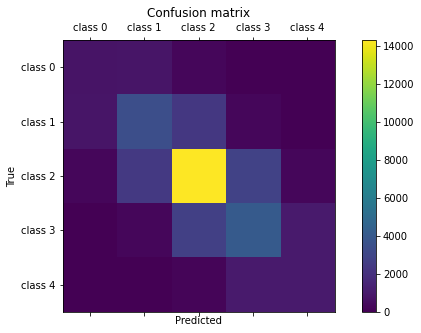

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
pipe_tfidf = make_pipeline(tfidf_vectorizer, knn)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

Realiza pruebas con varios clasificadores y configuraciones para el procesamiento de texto y contesta:

* De acuerdo con tus experimentos, ¿afecta más cambiar el clasificador o cómo se procesa el texto?
* ¿Has encontrado algún tipo de procesamiento que siempre mejore los resultados? ¿En qué hipótesis te has basado para probarlo?

In [52]:
#analyzer (para word_wb tambien n_gram), max_df, norm, use_idf, smooth_idf, sublinear_tf
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
# Tomamos para comparar los clasificadores que maximizaban arriba:
# Estos valores han sido óptimos en el estudio del apartado anterior
decision_tree = DecisionTreeClassifier(max_depth=131, criterion="gini")
knn = KNeighborsClassifier(n_neighbors=11, weights="distance", p=1)
red = MLPClassifier(early_stopping=True, learning_rate_init=0.0001, alpha=0.1, hidden_layer_sizes=(10,))

In [54]:
rango = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
for df in rango:
    vector = TfidfVectorizer(max_df=df)
    pipe_tree = make_pipeline(vector, decision_tree)
    pipe_knn = make_pipeline(vector, knn)
    pipe_red = make_pipeline(vector, red)
    print("max_df tree", df, get_accuracy(pipe_tree)) 
    print("max_df knn", df, get_accuracy(pipe_knn)) 
    print("max_df red", df, get_accuracy(pipe_red))

max_df tree 0.005 0.572
max_df knn 0.005 0.621
max_df red 0.005 0.628
max_df tree 0.01 0.584
max_df knn 0.01 0.626
max_df red 0.01 0.639
max_df tree 0.02 0.591
max_df knn 0.02 0.628
max_df red 0.02 0.643
max_df tree 0.03 0.592
max_df knn 0.03 0.627
max_df red 0.03 0.646
max_df tree 0.04 0.595
max_df knn 0.04 0.628
max_df red 0.04 0.648
max_df tree 0.05 0.597
max_df knn 0.05 0.627
max_df red 0.05 0.644


In [55]:
analyzers = ["word", "char", "char_wb"]
n_grams = [(1,1),(1,2),(2,2),(2,3),(1,3),(3,3),(7,7)]
for an in analyzers:
    if an == "char_wb":
        for n_g in n_grams:
            vector = TfidfVectorizer(analyzer=an, ngram_range=n_g)
            pipe_tree = make_pipeline(vector, decision_tree)
            pipe_knn = make_pipeline(vector, knn)
            pipe_red = make_pipeline(vector, red)
            print("analyzers tree", an, "n_gram_range:", n_g, get_accuracy(pipe_tree)) 
            print("analyzers knn", an, "n_gram_range:", n_g, get_accuracy(pipe_knn)) 
            print("analyzers red", an, "n_gram_range:", n_g, get_accuracy(pipe_red)) 
    else:
        vector = TfidfVectorizer(analyzer=an)
        pipe_tree = make_pipeline(vector, decision_tree)
        pipe_knn = make_pipeline(vector, knn)
        pipe_red = make_pipeline(vector, red)
        print("analyzers tree", an, n_g, get_accuracy(pipe_tree)) 
        print("analyzers knn", an, n_g, get_accuracy(pipe_knn)) 
        print("analyzers red", an, n_g, get_accuracy(pipe_red)) 

analyzers tree word (3, 3) 0.579
analyzers knn word (3, 3) 0.628
analyzers red word (3, 3) 0.645
analyzers tree char (3, 3) 0.438
analyzers knn char (3, 3) 0.596
analyzers red char (3, 3) 0.512
analyzers tree char_wb n_gram_range: (1, 1) 0.436
analyzers knn char_wb n_gram_range: (1, 1) 0.591
analyzers red char_wb n_gram_range: (1, 1) 0.512
analyzers tree char_wb n_gram_range: (1, 2) 0.487
analyzers knn char_wb n_gram_range: (1, 2) 0.641
analyzers red char_wb n_gram_range: (1, 2) 0.55
analyzers tree char_wb n_gram_range: (2, 2) 0.511
analyzers knn char_wb n_gram_range: (2, 2) 0.641
analyzers red char_wb n_gram_range: (2, 2) 0.547
analyzers tree char_wb n_gram_range: (2, 3) 0.528
analyzers knn char_wb n_gram_range: (2, 3) 0.643
analyzers red char_wb n_gram_range: (2, 3) 0.61
analyzers tree char_wb n_gram_range: (1, 3) 0.518
analyzers knn char_wb n_gram_range: (1, 3) 0.642
analyzers red char_wb n_gram_range: (1, 3) 0.607
analyzers tree char_wb n_gram_range: (3, 3) 0.559
analyzers knn char

In [56]:
normas = ["l1", "l2"]
for norma in normas:
    vector = TfidfVectorizer(norm=norma)
    pipe_tree = make_pipeline(vector, decision_tree)
    pipe_knn = make_pipeline(vector, knn)
    pipe_red = make_pipeline(vector, red)
    print("norm", norma, "tree", get_accuracy(pipe_tree)) 
    print("norm", norma, "knn", get_accuracy(pipe_knn)) 
    print("norm", norma, "red", get_accuracy(pipe_red)) 

norm l1 tree 0.575
norm l1 knn 0.606
norm l1 red 0.512
norm l2 tree 0.579
norm l2 knn 0.628
norm l2 red 0.648


In [57]:
booleans = [True, False]
for boo in booleans:
    vector = TfidfVectorizer(use_idf=boo)
    pipe_tree = make_pipeline(vector, decision_tree)
    pipe_knn = make_pipeline(vector, knn)
    pipe_red = make_pipeline(vector, red)
    print("use_idf tree", boo, get_accuracy(pipe_tree)) 
    print("use_idf knn", boo, get_accuracy(pipe_knn)) 
    print("use_idf red", boo, get_accuracy(pipe_red)) 

use_idf tree True 0.578
use_idf knn True 0.628
use_idf red True 0.645
use_idf tree False 0.582
use_idf knn False 0.619
use_idf red False 0.642


In [58]:
for boo in booleans:
    vector = TfidfVectorizer(smooth_idf=boo)
    pipe_tree = make_pipeline(vector, decision_tree)
    pipe_knn = make_pipeline(vector, knn)
    pipe_red = make_pipeline(vector, red)
    print("smooth_idf tree", boo, get_accuracy(pipe_tree)) 
    print("smooth_idf knn", boo, get_accuracy(pipe_knn)) 
    print("smooth_idf red", boo, get_accuracy(pipe_red)) 

smooth_idf tree True 0.58
smooth_idf knn True 0.628
smooth_idf red True 0.647
smooth_idf tree False 0.581
smooth_idf knn False 0.628
smooth_idf red False 0.645


In [59]:
for boo in booleans:
    vector = TfidfVectorizer(sublinear_tf=boo)
    pipe_tree = make_pipeline(vector, decision_tree)
    pipe_knn = make_pipeline(vector, knn)
    pipe_red = make_pipeline(vector, red)
    print("sublinear_tf tree", boo, get_accuracy(pipe_tree)) 
    print("sublinear_tf knn", boo, get_accuracy(pipe_knn)) 
    print("sublinear_tf red", boo, get_accuracy(pipe_red))

sublinear_tf tree True 0.583
sublinear_tf knn True 0.628
sublinear_tf red True 0.64
sublinear_tf tree False 0.579
sublinear_tf knn False 0.628
sublinear_tf red False 0.644


#### **Conclusiones**
En general, se han ejecutado las diferentes mejoras en el procesamiento de texto para el mejor valor obtenido en el estudio del ejercicio anterior.
Así pues, si los resultados son mejores a los obtenidos para esos hiperparámetros, concluiremos que el procesado de texto aporta positivamemte - puede o no ser de forma significativa - a la precisión del modelo.

Para todos los modelos hemos variado los siguientes parámetros:
- max_df: elimina las palabras con frecuencia acumulada extricamente mayor a este parámetro
- analyzers: configuración de las unidades a analizar
- norm: emplea la norma l1 o l1
- use_idf: reponderación de frecuencia
- smooth_idf: evita las divisiones por 0, añadiendo 1 a la frecuencia de todos los elementos
- sublinear_tf: cambia tf por 1 + log(tf)

**Árbol de decisión**
Se aprecia que los resultados no son mejores que con el procesado de texto. De hecho, ningñun cambio alcanza la cifra de precisión máxima obtenida, en torno al 0.6, aunque algunos se queden cerca. Al variar el parámetro max_df se observa que cuanto mayor sea este, es decir, cuanto mayor sea la frecuencia necesaria para eliminar palabras, mayor es el aumento obtenido. Los resultados tienen sentido, ya que palabras comunes tienden a ser conectores, preposiciones, artículos, que no aportan sustancialmente a las connotaciones de las clases. Cabe destacar que entre las opciones *analyzer*, la mejor es word. Los últimos cuatro parámetros no parecen tener mucha influencia en los resultados.


**Vecinos próximos**
Se trata del mejor modelo, y que más se ve beneficiado por el procesamiento del texto.
Eliminar las frecuencias de las palabras tiene un efecto manifiestamente positivo respecto de los resultados obtenidos en el ejercicio anterior, aunque todos los valores excepto el primero - es muy pequeño - arrojan los mismos resultados.
Este modelo se ve particularmente beneficiado por el uso del analyzer *char_wb*, a diferencia del árbol de decisión. Se trata de las mejores marcas de precisión del estudio.
Cabe destacar que es preferible el uso de norma *l2*, mejorando los resultados de precisión en un 2%. El resto de parámetros no muestran evidencia suficiente para inclinarse hacia el uso de uno en específico.


**Red neuronal**
En este caso, el comportamiento de la variación de max_df es similar al del árbol de decisión. El uso del analyzer *word* muestra los mejores resultados de precisión, siendo solamente superado por *char_wb* con valor de exclusivamente  7-gramas - (7,7) -, aunque este segundo tiene un coste temporal significativamente mayor.
El resto de parámetros mejoran los resultados de precisión, aunque indistintamente.


*De acuerdo con tus experimentos, ¿afecta más cambiar el clasificador o cómo se procesa el texto?*
Cambiar el clasificador puede tener un efecto muy negativo, aunque se observa que en ciertos casos del procesamiento de texto, como puede ser un valor de n para los n-gramas en *char_wb* también pueden empeorar los resultados. El uso de ambas técnicas arroja los mejores resultados, con aumentos comparables de la precisión, por lo que la combinación de ambas técnicas es óptima.

*¿Has encontrado algún tipo de procesamiento que siempre mejore los resultados? ¿En qué hipótesis te has basado para probarlo?*
La eliminación de frecuencias repetidas mejora siempre los resultados. La hipótesis es sencilla y ya ha sido expuesta: palabras comunes tienden a ser conectores, preposiciones, artículos, que no aportan sustancialmente a las connotaciones de las clases. Además, como hay muchos ejemplos de una clase, y pocos de las otras, quitar las palabras comunes disminuirá en mayor proporción los elementos de la clase mayoritaria.



In [ ]:
#Resultados para arboles:
#
#max_df tree 0.005 0.572
#max_df tree 0.01 0.584
#max_df tree 0.02 0.591
#max_df tree 0.03 0.592
#max_df tree 0.04 0.595
#max_df tree 0.05 0.597
#analyzers tree word (3, 3) 0.579
#analyzers tree char (3, 3) 0.438
#analyzers tree char_wb n_gram_range: (1, 1) 0.436
#analyzers tree char_wb n_gram_range: (1, 2) 0.487
#analyzers tree char_wb n_gram_range: (2, 2) 0.511
#analyzers tree char_wb n_gram_range: (2, 3) 0.528
#analyzers tree char_wb n_gram_range: (1, 3) 0.518
#analyzers tree char_wb n_gram_range: (3, 3) 0.559
#analyzers tree char_wb n_gram_range: (7, 7) 0.57
#norm l1 tree 0.575
#norm l2 tree 0.579
#use_idf tree True 0.578
#use_idf tree False 0.582
#smooth_idf tree True 0.58
#smooth_idf tree False 0.581
#sublinear_tf tree True 0.583
#sublinear_tf tree False 0.579

In [ ]:
#Resultados para knn:
#
#max_df knn 0.005 0.621
#max_df knn 0.01 0.626
#max_df knn 0.02 0.628
#max_df knn 0.03 0.627
#max_df knn 0.04 0.628
#max_df knn 0.05 0.627
#analyzers knn word (3, 3) 0.628
#analyzers knn char (3, 3) 0.596
#analyzers knn char_wb n_gram_range: (1, 1) 0.591
#analyzers knn char_wb n_gram_range: (1, 2) 0.641
#analyzers knn char_wb n_gram_range: (2, 2) 0.641
#analyzers knn char_wb n_gram_range: (2, 3) 0.643
#analyzers knn char_wb n_gram_range: (1, 3) 0.642
#analyzers knn char_wb n_gram_range: (3, 3) 0.642
#analyzers knn char_wb n_gram_range: (7, 7) 0.637
#norm l1 knn 0.606
#norm l2 knn 0.628
#use_idf knn True 0.628
#use_idf knn False 0.619
#smooth_idf knn True 0.628
#smooth_idf knn False 0.628
#sublinear_tf knn True 0.628
#sublinear_tf knn False 0.628

In [ ]:
#Resultados para redes:
#
#max_df red 0.005 0.628
#max_df red 0.01 0.639
#max_df red 0.02 0.643
#max_df red 0.03 0.646
#max_df red 0.04 0.648
#max_df red 0.05 0.644
#analyzers red word (3, 3) 0.645
#analyzers red char (3, 3) 0.512
#analyzers red char_wb n_gram_range: (1, 1) 0.512
#analyzers red char_wb n_gram_range: (1, 2) 0.55
#analyzers red char_wb n_gram_range: (2, 2) 0.547
#analyzers red char_wb n_gram_range: (2, 3) 0.61
#analyzers red char_wb n_gram_range: (1, 3) 0.607
#analyzers red char_wb n_gram_range: (3, 3) 0.616
#analyzers red char_wb n_gram_range: (7, 7) 0.65
#norm l1 red 0.512
#norm l2 red 0.648
#use_idf red True 0.645
#use_idf red False 0.642
#smooth_idf red True 0.647
#smooth_idf red False 0.645
#sublinear_tf red True 0.64
#sublinear_tf red False 0.644